In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [3]:
# or any other image dataset with cv2.addWeighted("black_image") to get dark picture

image_paths = glob("/kaggle/input/exdark-dataset/" + "*/*.jpg")
image_paths = np.array(image_paths)

np.random.shuffle(image_paths)

train_size = int(len(image_paths) * 0.9)
train_images = image_paths[:train_size]

val_size = 500

valid_images = image_paths[train_size: train_size+val_size]
test_images = image_paths[train_size+val_size:]

print(f"Train size: {len(train_images)}, valid size: {len(valid_images)}, test size: {len(test_images)}")

Train size: 5575, valid size: 500, test size: 120


In [4]:
class LowLightDataset(Dataset):
    def __init__(self, data, image_size=128):
        self.data = data
        self.image_size = image_size
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        image = Image.open(self.data[ix]).convert("RGB")
        
        image = T.Compose([
            T.Resize((self.image_size, self.image_size)),
            T.ToTensor()
        ])(image)
        
        return image.to(device)

In [5]:
train_ds = LowLightDataset(train_images)
valid_ds = LowLightDataset(valid_images)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, drop_last=True)

**Losses**

In [6]:
class ColorConstancyLoss(nn.Module):
    def forward(self, x):
        mean_rgb = torch.mean(x, dim=[2,3], keepdim=True)
        red, green, blue = mean_rgb[:, 0, :, :], mean_rgb[:, 1, :, :], mean_rgb[:, 2, :, :]
        ls_rg = torch.square(red - green)
        ls_rb = torch.square(red - blue)
        ls_gb = torch.square(blue - green)
        under_sqrt = torch.square(ls_rg) + torch.square(ls_rb) + torch.square(ls_gb)
        
        color_loss = torch.sqrt(under_sqrt)
        return color_loss
    
class ExposureLoss(nn.Module):
    def forward(self, x, mean_val=0.6):
        x = torch.mean(x, dim=1, keepdim=True)
        mean = F.avg_pool2d(x, kernel_size=16, stride=16, padding=0)
        exposure_loss = torch.square(mean - mean_val)
        return torch.mean(exposure_loss)
    
class IlluminationLoss(nn.Module):
    def forward(self, x):
        batch_size, c_x, h_x, w_x = x.size()
        count_h = (w_x - 1) * c_x
        count_w = w_x * (c_x - 1)
        h_tv = torch.sum(torch.square(x[:, :, 1:, :] - x[:, :, :h_x - 1, :]))
        w_tv = torch.sum(torch.square(x[:, :, :, 1:] - x[:, :, :, :w_x - 1]))
        return 2 * (h_tv / count_h + w_tv / count_w) / batch_size
    
class SpatialConsistancyLoss(nn.Module):
    def __init__(self, device=device, **kwargs):
        super(SpatialConsistancyLoss, self).__init__(**kwargs)
        
        kernel_left = torch.FloatTensor([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])[None, None, :].to(device)
        kernel_right = torch.FloatTensor([[0, 0, 0], [0, 1, -1], [0, 0, 0]])[None, None, :].to(device)
        kernel_up = torch.FloatTensor([[0, -1, 0], [0, 1, 0], [0, 0, 0]])[None, None, :].to(device)
        kernel_down = torch.FloatTensor([[0, 0, 0], [0, 1, 0], [0, -1, 0]])[None, None, :].to(device)

        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        
        self.pool = nn.AvgPool2d(kernel_size=4, stride=4)
        
    def forward(self, enhanced, original):
        original_mean = torch.mean(original, dim=1, keepdim=True)
        enhanced_mean = torch.mean(enhanced, dim=1, keepdim=True)
        original_pool = self.pool(original_mean)
        enhanced_pool = self.pool(enhanced_mean)

        original_left = F.conv2d(original_pool, self.weight_left, padding=1)
        original_right = F.conv2d(original_pool, self.weight_right, padding=1)
        original_up = F.conv2d(original_pool, self.weight_up, padding=1)
        original_down = F.conv2d(original_pool, self.weight_down, padding=1)

        enhanced_left = F.conv2d(enhanced_pool, self.weight_left, padding=1)
        enhanced_right = F.conv2d(enhanced_pool, self.weight_right, padding=1)
        enhanced_up = F.conv2d(enhanced_pool, self.weight_up, padding=1)
        enhanced_down = F.conv2d(enhanced_pool, self.weight_down, padding=1)

        left = torch.square(original_left - enhanced_left)
        right = torch.square(original_right - enhanced_right)
        up = torch.square(original_up - enhanced_up)
        down = torch.square(original_down - enhanced_down)
        return left + right + up + down
    
class DCELoss(nn.Module):
    def __init__(self, tv_scale=200.0, spa_scale=1.0, col_scale=5.0, exp_scale=10.0, device=device, **kwargs):
        super(DCELoss, self).__init__(**kwargs)
        
        self.illumination = IlluminationLoss()
        self.spatial = SpatialConsistancyLoss(device)
        self.color = ColorConstancyLoss()
        self.exposure = ExposureLoss()
        
        self.tv_scale = tv_scale
        self.spa_scale = spa_scale
        self.col_scale = col_scale
        self.exp_scale = exp_scale
        
    def forward(self, enhanced_image, image_lowlight, x_out):
        loss_tv = self.illumination(x_out)
        loss_spatial = self.spatial(enhanced_image, image_lowlight).mean()
        loss_color = self.color(enhanced_image).mean()
        loss_exposure = self.exposure(enhanced_image).mean()
        
        loss = self.tv_scale * loss_tv + self.spa_scale * loss_spatial + self.col_scale * loss_color + self.exp_scale * loss_exposure
        return loss

**DCE model**

<table>
    <tr><td>
<img src=https://i.imgur.com/HtIg34W.png width=800></td>
        <td>
<img src=https://raw.githubusercontent.com/Thehunk1206/Zero-DCE/master/image_assets/Proposed_Architecture.png width=800></td>
        </tr>
    </table>

In [7]:
class DCEModel(nn.Module):
    def __init__(self, num_filters=32, **kwargs):
        super(DCEModel, self).__init__(**kwargs)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters,
                               kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters,
                               kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters,
                               kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters,
                               kernel_size=3, stride=1, padding=1, bias=True)

        self.conv5 = nn.Conv2d(in_channels=num_filters * 2, out_channels=num_filters,
                               kernel_size=3, stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=num_filters * 2, out_channels=num_filters,
                               kernel_size=3, stride=1, padding=1, bias=True)
        self.conv7 = nn.Conv2d(in_channels=num_filters * 2, out_channels=24,
                               kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        
        self._init_weights()

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        x4 = self.relu(self.conv4(x3))
        
        x5 = self.relu(self.conv5(torch.cat([x3, x4], dim=1)))
        x6 = self.relu(self.conv6(torch.cat([x2, x5], dim=1)))
        x_out = self.tanh(self.conv7(torch.cat([x1, x6], dim=1)))  # [B, 24, H, W]

        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_out, split_size_or_sections=3, dim=1)  # each [B, 3, H, W]
        x = x + r1 * (torch.square(x) - x)
        x = x + r2 * (torch.square(x) - x)
        x = x + r3 * (torch.square(x) - x)
        enhanced_image = x + r4 * (torch.square(x) - x)
        
        x = enhanced_image + r5 * (torch.square(enhanced_image) - enhanced_image)
        x = x + r6 * (torch.square(x) - x)
        x = x + r7 * (torch.square(x) - x)
        enhanced_image = x + r8 * (torch.square(x) - x)
        
        return enhanced_image, x_out

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

**Train / eval / test functions**

In [8]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    
    optimizer.zero_grad()
    enhanced_image, x_out = model(data)
    
    loss = criterion(enhanced_image, data, x_out)
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    enhanced_image, x_out = model(data)
    
    loss = criterion(enhanced_image, data, x_out)
    return loss.item()

@torch.no_grad()
def test_plot(model, data=test_images):
    idx = np.random.randint(len(data))
    path = data[idx]
    lowlight_image = Image.open(path)
    input_image = T.Compose([
            T.Resize((train_ds.image_size, train_ds.image_size)),
            T.ToTensor()
        ])(lowlight_image)
    model.eval()

    enhanced_image, _ = model(input_image.unsqueeze(0).to(device))
    
    enhanced_image = T.ToPILImage()(enhanced_image.squeeze(0).detach().cpu())
    
    plt.figure(figsize=(8, 6))
    
    plt.subplot(121)
    plt.title("Lowlight image")
    plt.imshow(lowlight_image.resize((train_ds.image_size, train_ds.image_size)))
    
    plt.subplot(122)
    plt.title("Lightened image")
    plt.imshow(enhanced_image)
    
    plt.tight_layout()
    plt.show()

In [9]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None, **kwargs):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {'model': DCEModel(**kwargs),
                          'state_dict': model.state_dict(),
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [10]:
model = DCEModel().to(device)

criterion = DCELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, min_lr=1e-7)

stopper = EarlyStopping(patience=3)

epoch: 1 	step: 20 / 87 	train loss: 43.1071 	time: 2.7059 s
epoch: 1 	step: 40 / 87 	train loss: 22.5563 	time: 2.7071 s
epoch: 1 	step: 60 / 87 	train loss: 14.5676 	time: 2.7064 s
epoch: 1 	step: 80 / 87 	train loss: 10.1354 	time: 2.7067 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 35.5655 	valid loss: 9.2301


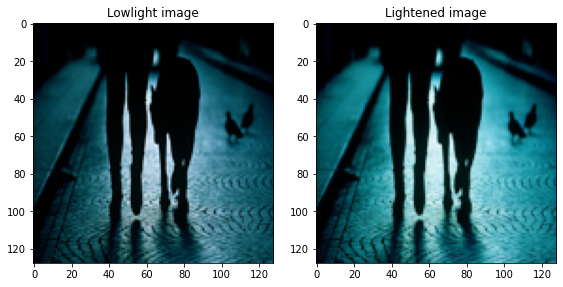

epoch: 2 	step: 20 / 87 	train loss: 7.3931 	time: 2.7037 s
epoch: 2 	step: 40 / 87 	train loss: 5.1243 	time: 2.7069 s
epoch: 2 	step: 60 / 87 	train loss: 5.2070 	time: 2.7112 s
epoch: 2 	step: 80 / 87 	train loss: 3.9720 	time: 2.7037 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2 / 40 	train loss: 5.6958 	valid loss: 4.0291
Model saved to: model.pth


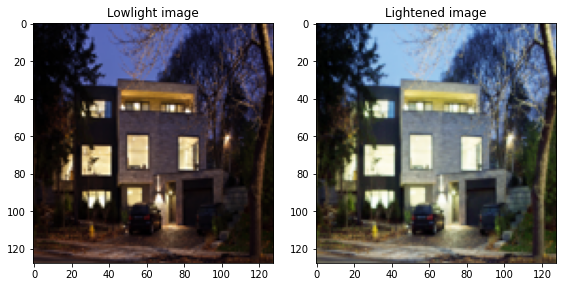

epoch: 3 	step: 20 / 87 	train loss: 3.2064 	time: 2.7083 s
epoch: 3 	step: 40 / 87 	train loss: 2.7113 	time: 2.7087 s
epoch: 3 	step: 60 / 87 	train loss: 2.1715 	time: 2.7103 s
epoch: 3 	step: 80 / 87 	train loss: 1.9450 	time: 2.7072 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 3 / 40 	train loss: 2.7144 	valid loss: 1.9612
Model saved to: model.pth


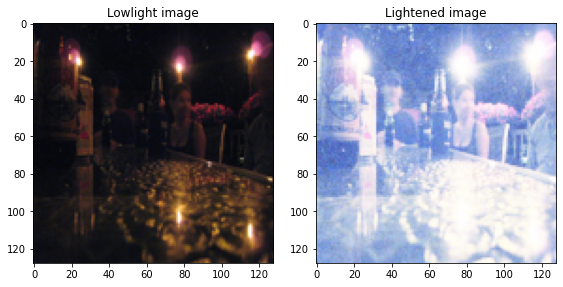

epoch: 4 	step: 20 / 87 	train loss: 1.7700 	time: 2.7059 s
epoch: 4 	step: 40 / 87 	train loss: 1.6188 	time: 2.7033 s
epoch: 4 	step: 60 / 87 	train loss: 1.5900 	time: 2.7059 s
epoch: 4 	step: 80 / 87 	train loss: 1.5155 	time: 2.7053 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 4 / 40 	train loss: 1.6323 	valid loss: 1.5207
Model saved to: model.pth


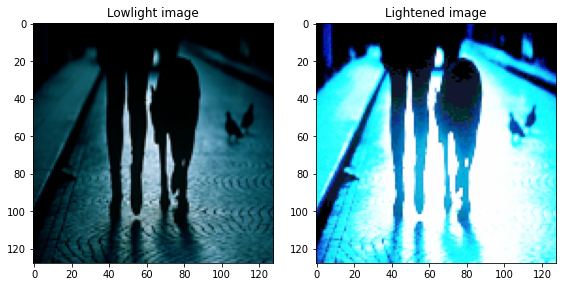

epoch: 5 	step: 20 / 87 	train loss: 1.4586 	time: 2.7004 s
epoch: 5 	step: 40 / 87 	train loss: 1.3534 	time: 2.7076 s
epoch: 5 	step: 60 / 87 	train loss: 1.3840 	time: 2.7032 s
epoch: 5 	step: 80 / 87 	train loss: 1.3348 	time: 2.7113 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 5 / 40 	train loss: 1.4089 	valid loss: 1.4185
Model saved to: model.pth


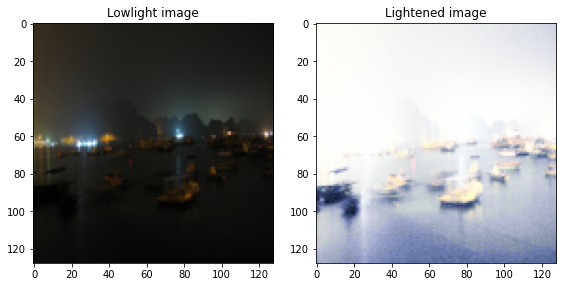

epoch: 6 	step: 20 / 87 	train loss: 1.3028 	time: 2.7026 s
epoch: 6 	step: 40 / 87 	train loss: 1.4040 	time: 2.7051 s
epoch: 6 	step: 60 / 87 	train loss: 1.4422 	time: 2.7029 s
epoch: 6 	step: 80 / 87 	train loss: 1.3887 	time: 2.7046 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 6 / 40 	train loss: 1.3502 	valid loss: 1.3781
Model saved to: model.pth


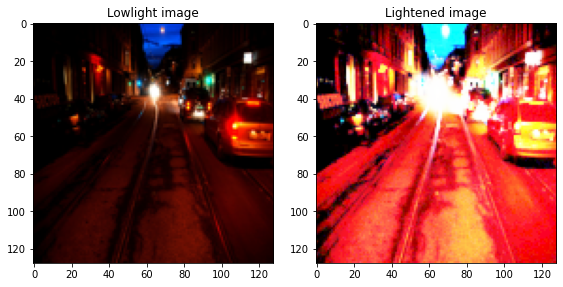

epoch: 7 	step: 20 / 87 	train loss: 1.3581 	time: 2.7013 s
epoch: 7 	step: 40 / 87 	train loss: 1.3190 	time: 2.7147 s
epoch: 7 	step: 60 / 87 	train loss: 1.3518 	time: 2.7009 s
epoch: 7 	step: 80 / 87 	train loss: 1.4298 	time: 2.7037 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 7 / 40 	train loss: 1.3220 	valid loss: 1.3537
Model saved to: model.pth


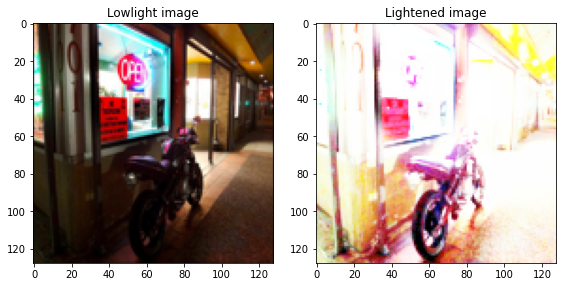

epoch: 8 	step: 20 / 87 	train loss: 1.2982 	time: 2.7074 s
epoch: 8 	step: 40 / 87 	train loss: 1.3290 	time: 2.7035 s
epoch: 8 	step: 60 / 87 	train loss: 1.2843 	time: 2.7074 s
epoch: 8 	step: 80 / 87 	train loss: 1.2384 	time: 2.7055 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 8 / 40 	train loss: 1.2982 	valid loss: 1.3304
Model saved to: model.pth


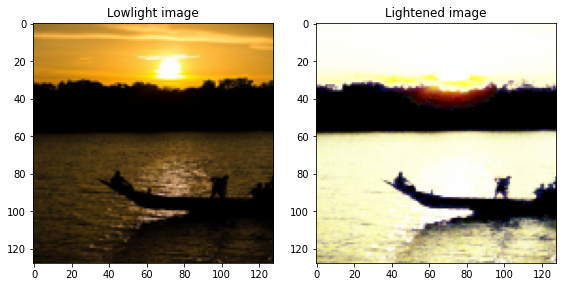

epoch: 9 	step: 20 / 87 	train loss: 1.2797 	time: 2.7064 s
epoch: 9 	step: 40 / 87 	train loss: 1.2921 	time: 2.7043 s
epoch: 9 	step: 60 / 87 	train loss: 1.3157 	time: 2.7049 s
epoch: 9 	step: 80 / 87 	train loss: 1.4234 	time: 2.7063 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 9 / 40 	train loss: 1.2735 	valid loss: 1.3082
Model saved to: model.pth


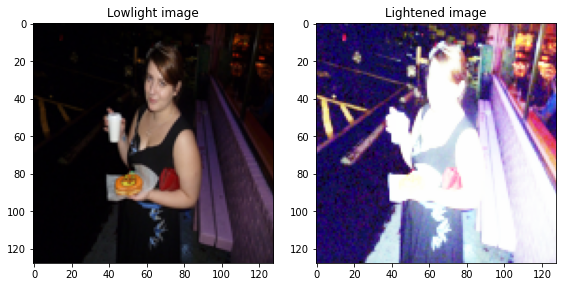

epoch: 10 	step: 20 / 87 	train loss: 1.2113 	time: 2.7028 s
epoch: 10 	step: 40 / 87 	train loss: 1.1908 	time: 2.7020 s
epoch: 10 	step: 60 / 87 	train loss: 1.2593 	time: 2.7035 s
epoch: 10 	step: 80 / 87 	train loss: 1.1910 	time: 2.7056 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 10 / 40 	train loss: 1.2555 	valid loss: 1.2872
Model saved to: model.pth


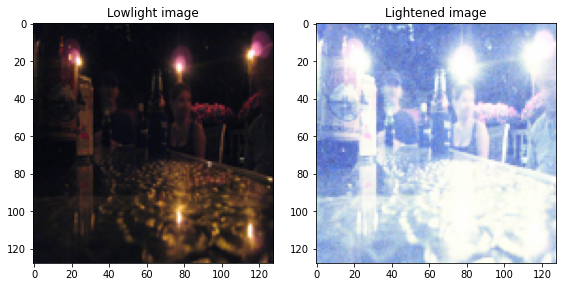

epoch: 11 	step: 20 / 87 	train loss: 1.2533 	time: 2.7042 s
epoch: 11 	step: 40 / 87 	train loss: 1.1377 	time: 2.7042 s
epoch: 11 	step: 60 / 87 	train loss: 1.2269 	time: 2.7064 s
epoch: 11 	step: 80 / 87 	train loss: 1.1958 	time: 2.7027 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 11 / 40 	train loss: 1.2413 	valid loss: 1.2738
Model saved to: model.pth


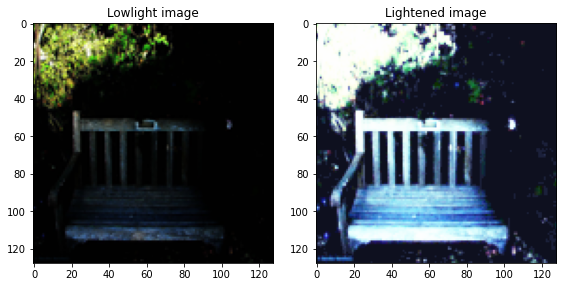

epoch: 12 	step: 20 / 87 	train loss: 1.3292 	time: 2.7079 s
epoch: 12 	step: 40 / 87 	train loss: 1.2999 	time: 2.6993 s
epoch: 12 	step: 60 / 87 	train loss: 1.2828 	time: 2.7030 s
epoch: 12 	step: 80 / 87 	train loss: 1.2058 	time: 2.7068 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 12 / 40 	train loss: 1.2302 	valid loss: 1.2670
Model saved to: model.pth


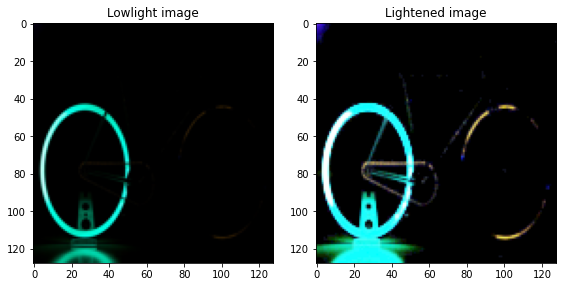

epoch: 13 	step: 20 / 87 	train loss: 1.1767 	time: 2.7084 s
epoch: 13 	step: 40 / 87 	train loss: 1.1566 	time: 2.7050 s
epoch: 13 	step: 60 / 87 	train loss: 1.2127 	time: 2.7023 s
epoch: 13 	step: 80 / 87 	train loss: 1.1752 	time: 2.7006 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 13 / 40 	train loss: 1.2201 	valid loss: 1.2573
Model saved to: model.pth


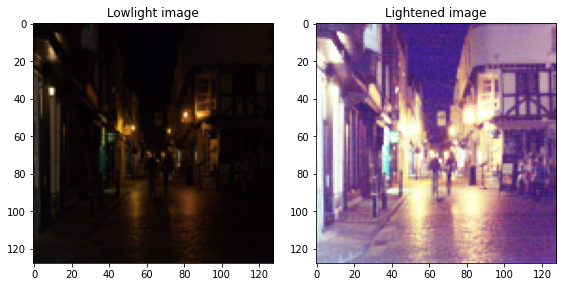

epoch: 14 	step: 20 / 87 	train loss: 1.2393 	time: 2.7014 s
epoch: 14 	step: 40 / 87 	train loss: 1.3736 	time: 2.7070 s
epoch: 14 	step: 60 / 87 	train loss: 1.1805 	time: 2.7042 s
epoch: 14 	step: 80 / 87 	train loss: 1.1179 	time: 2.7111 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 14 / 40 	train loss: 1.2116 	valid loss: 1.2445
Model saved to: model.pth


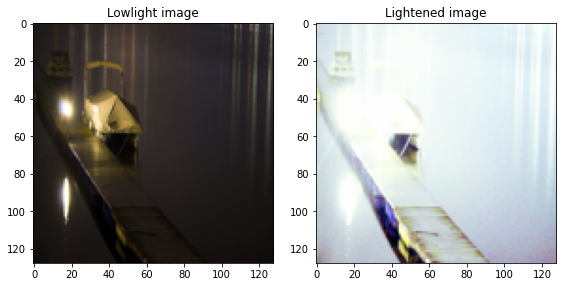

epoch: 15 	step: 20 / 87 	train loss: 1.2142 	time: 2.7054 s
epoch: 15 	step: 40 / 87 	train loss: 1.0851 	time: 2.7075 s
epoch: 15 	step: 60 / 87 	train loss: 1.2650 	time: 2.7116 s
epoch: 15 	step: 80 / 87 	train loss: 1.1754 	time: 2.7081 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 15 / 40 	train loss: 1.2017 	valid loss: 1.2373
Model saved to: model.pth


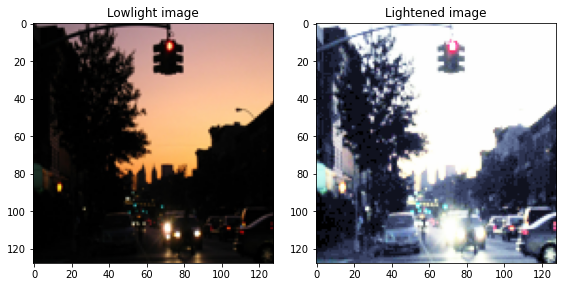

epoch: 16 	step: 20 / 87 	train loss: 1.3480 	time: 2.7066 s
epoch: 16 	step: 40 / 87 	train loss: 1.2813 	time: 2.7059 s
epoch: 16 	step: 60 / 87 	train loss: 1.1318 	time: 2.7085 s
epoch: 16 	step: 80 / 87 	train loss: 1.2362 	time: 2.7047 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 16 / 40 	train loss: 1.1940 	valid loss: 1.2259
Model saved to: model.pth


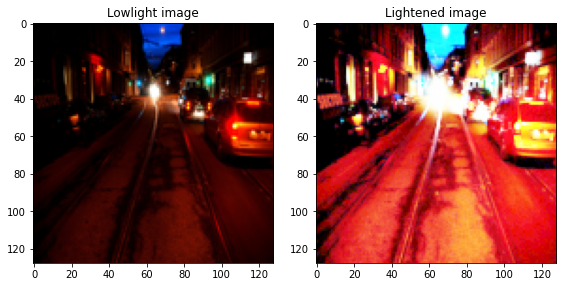

epoch: 17 	step: 20 / 87 	train loss: 1.2728 	time: 2.7082 s
epoch: 17 	step: 40 / 87 	train loss: 1.1211 	time: 2.7088 s
epoch: 17 	step: 60 / 87 	train loss: 1.1426 	time: 2.7061 s
epoch: 17 	step: 80 / 87 	train loss: 1.2111 	time: 2.7058 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 17 / 40 	train loss: 1.1857 	valid loss: 1.2167
Model saved to: model.pth


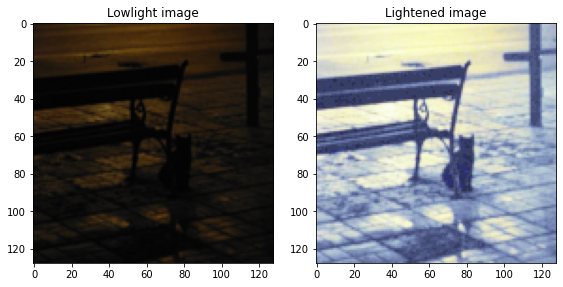

epoch: 18 	step: 20 / 87 	train loss: 1.1696 	time: 2.7065 s
epoch: 18 	step: 40 / 87 	train loss: 1.2581 	time: 2.7039 s
epoch: 18 	step: 60 / 87 	train loss: 1.1747 	time: 2.7014 s
epoch: 18 	step: 80 / 87 	train loss: 1.0533 	time: 2.7040 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 18 / 40 	train loss: 1.1765 	valid loss: 1.2109
Model saved to: model.pth


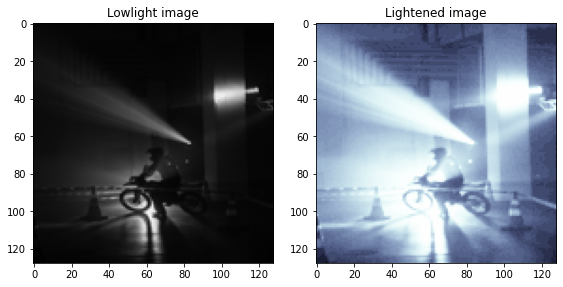

epoch: 19 	step: 20 / 87 	train loss: 1.0261 	time: 2.7046 s
epoch: 19 	step: 40 / 87 	train loss: 1.1411 	time: 2.7106 s
epoch: 19 	step: 60 / 87 	train loss: 1.1421 	time: 2.7052 s
epoch: 19 	step: 80 / 87 	train loss: 1.2253 	time: 2.7049 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 19 / 40 	train loss: 1.1702 	valid loss: 1.1990
Model saved to: model.pth


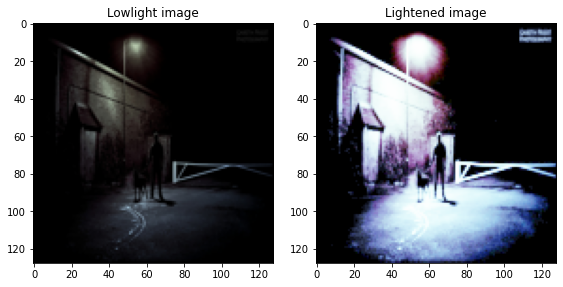

epoch: 20 	step: 20 / 87 	train loss: 1.2609 	time: 2.7026 s
epoch: 20 	step: 40 / 87 	train loss: 1.1405 	time: 2.7060 s
epoch: 20 	step: 60 / 87 	train loss: 1.2998 	time: 2.7076 s
epoch: 20 	step: 80 / 87 	train loss: 1.0273 	time: 2.7054 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 20 / 40 	train loss: 1.1630 	valid loss: 1.1992
INFO: Early stopping counter 1 of 3


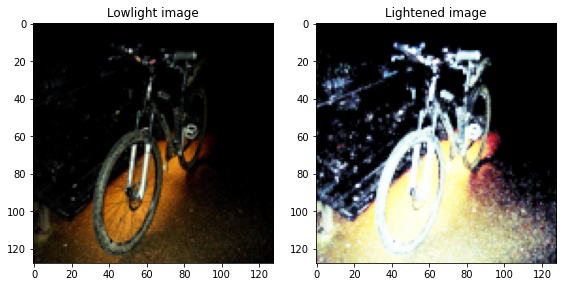

epoch: 21 	step: 20 / 87 	train loss: 1.1447 	time: 2.7052 s
epoch: 21 	step: 40 / 87 	train loss: 1.1753 	time: 2.7054 s
epoch: 21 	step: 60 / 87 	train loss: 1.2812 	time: 2.7092 s
epoch: 21 	step: 80 / 87 	train loss: 1.1093 	time: 2.7132 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 21 / 40 	train loss: 1.1556 	valid loss: 1.1844
Model saved to: model.pth


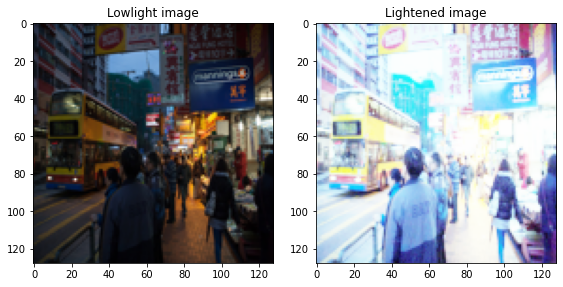

epoch: 22 	step: 20 / 87 	train loss: 1.1597 	time: 2.7072 s
epoch: 22 	step: 40 / 87 	train loss: 1.0371 	time: 2.7117 s
epoch: 22 	step: 60 / 87 	train loss: 1.0767 	time: 2.7076 s
epoch: 22 	step: 80 / 87 	train loss: 1.1179 	time: 2.7076 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 22 / 40 	train loss: 1.1491 	valid loss: 1.1789
Model saved to: model.pth


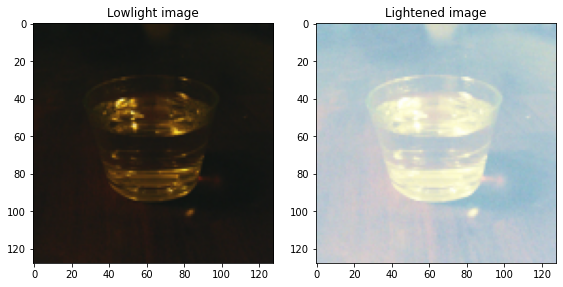

epoch: 23 	step: 20 / 87 	train loss: 1.1385 	time: 2.7087 s
epoch: 23 	step: 40 / 87 	train loss: 1.2969 	time: 2.7071 s
epoch: 23 	step: 60 / 87 	train loss: 1.1323 	time: 2.7016 s
epoch: 23 	step: 80 / 87 	train loss: 1.1413 	time: 2.7041 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 23 / 40 	train loss: 1.1423 	valid loss: 1.1853
INFO: Early stopping counter 1 of 3


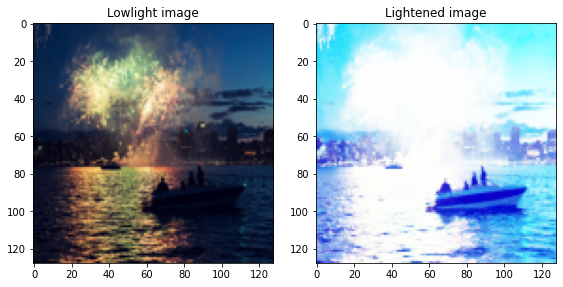

epoch: 24 	step: 20 / 87 	train loss: 1.1054 	time: 2.6999 s
epoch: 24 	step: 40 / 87 	train loss: 1.0717 	time: 2.7030 s
epoch: 24 	step: 60 / 87 	train loss: 1.1364 	time: 2.7065 s
epoch: 24 	step: 80 / 87 	train loss: 1.2487 	time: 2.7043 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 24 / 40 	train loss: 1.1374 	valid loss: 1.1638
Model saved to: model.pth


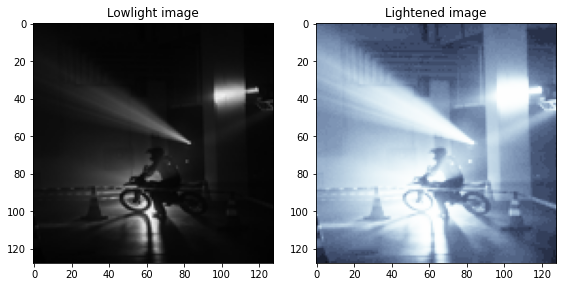

epoch: 25 	step: 20 / 87 	train loss: 1.1747 	time: 2.7093 s
epoch: 25 	step: 40 / 87 	train loss: 1.1635 	time: 2.7099 s
epoch: 25 	step: 60 / 87 	train loss: 1.0862 	time: 2.7052 s
epoch: 25 	step: 80 / 87 	train loss: 1.0750 	time: 2.7048 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 25 / 40 	train loss: 1.1317 	valid loss: 1.1623
Model saved to: model.pth


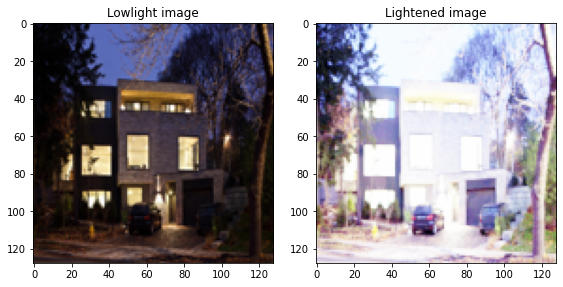

epoch: 26 	step: 20 / 87 	train loss: 1.2879 	time: 2.7045 s
epoch: 26 	step: 40 / 87 	train loss: 1.0882 	time: 2.7061 s
epoch: 26 	step: 60 / 87 	train loss: 1.2997 	time: 2.7077 s
epoch: 26 	step: 80 / 87 	train loss: 1.0260 	time: 2.7131 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 26 / 40 	train loss: 1.1232 	valid loss: 1.1514
Model saved to: model.pth


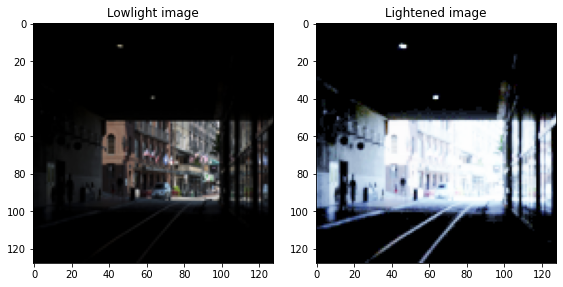

epoch: 27 	step: 20 / 87 	train loss: 1.1575 	time: 2.7065 s
epoch: 27 	step: 40 / 87 	train loss: 1.1182 	time: 2.7066 s
epoch: 27 	step: 60 / 87 	train loss: 1.0838 	time: 2.7051 s
epoch: 27 	step: 80 / 87 	train loss: 1.2221 	time: 2.7041 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 27 / 40 	train loss: 1.1113 	valid loss: 1.1485
Model saved to: model.pth


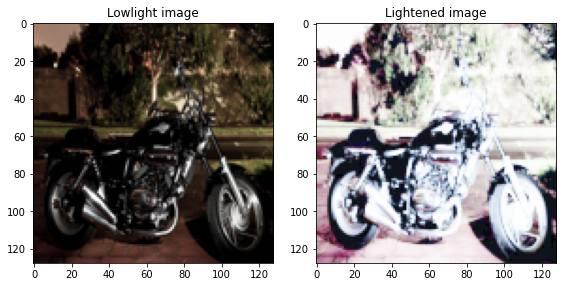

epoch: 28 	step: 20 / 87 	train loss: 1.0424 	time: 2.7059 s
epoch: 28 	step: 40 / 87 	train loss: 1.0722 	time: 2.7045 s
epoch: 28 	step: 60 / 87 	train loss: 0.9843 	time: 2.7075 s
epoch: 28 	step: 80 / 87 	train loss: 1.0785 	time: 2.7114 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 28 / 40 	train loss: 1.1049 	valid loss: 1.1465
Model saved to: model.pth


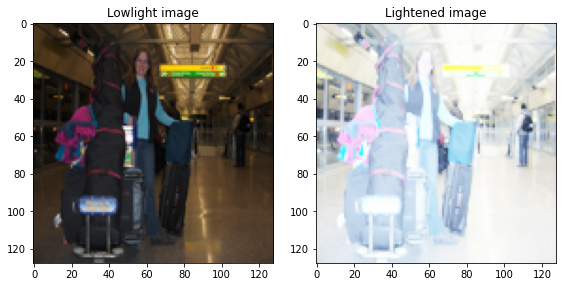

epoch: 29 	step: 20 / 87 	train loss: 1.1062 	time: 2.7098 s
epoch: 29 	step: 40 / 87 	train loss: 1.1839 	time: 2.7049 s
epoch: 29 	step: 60 / 87 	train loss: 1.0842 	time: 2.7167 s
epoch: 29 	step: 80 / 87 	train loss: 1.3491 	time: 2.7045 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 29 / 40 	train loss: 1.1022 	valid loss: 1.1363
Model saved to: model.pth


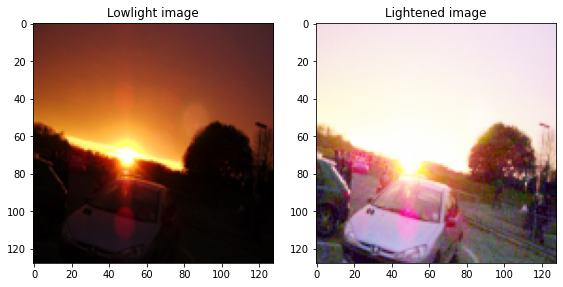

epoch: 30 	step: 20 / 87 	train loss: 1.1191 	time: 2.7045 s
epoch: 30 	step: 40 / 87 	train loss: 1.0169 	time: 2.7080 s
epoch: 30 	step: 60 / 87 	train loss: 0.9894 	time: 2.7080 s
epoch: 30 	step: 80 / 87 	train loss: 1.0580 	time: 2.7097 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 30 / 40 	train loss: 1.0946 	valid loss: 1.1217
Model saved to: model.pth


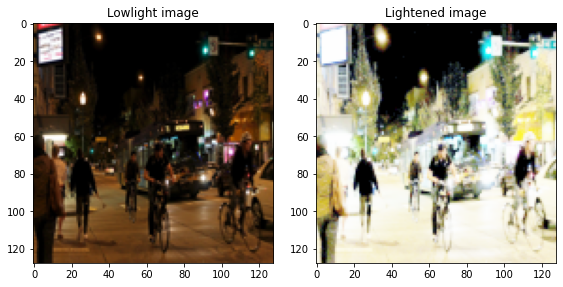

epoch: 31 	step: 20 / 87 	train loss: 1.3312 	time: 2.7020 s
epoch: 31 	step: 40 / 87 	train loss: 1.0033 	time: 2.7067 s
epoch: 31 	step: 60 / 87 	train loss: 1.1037 	time: 2.7060 s
epoch: 31 	step: 80 / 87 	train loss: 1.0817 	time: 2.7130 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 31 / 40 	train loss: 1.0901 	valid loss: 1.1147
Model saved to: model.pth


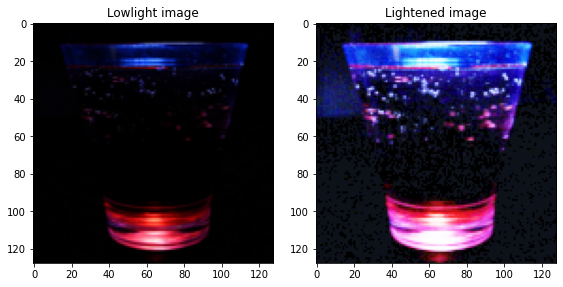

epoch: 32 	step: 20 / 87 	train loss: 1.1323 	time: 2.7100 s
epoch: 32 	step: 40 / 87 	train loss: 1.1138 	time: 2.7053 s
epoch: 32 	step: 60 / 87 	train loss: 0.9875 	time: 2.7040 s
epoch: 32 	step: 80 / 87 	train loss: 0.9228 	time: 2.7054 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 32 / 40 	train loss: 1.0831 	valid loss: 1.1105
Model saved to: model.pth


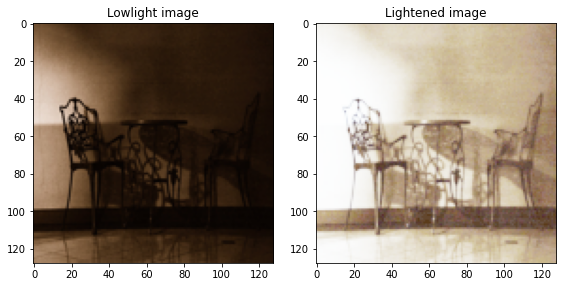

epoch: 33 	step: 20 / 87 	train loss: 0.9741 	time: 2.7046 s
epoch: 33 	step: 40 / 87 	train loss: 1.1588 	time: 2.7089 s
epoch: 33 	step: 60 / 87 	train loss: 1.1738 	time: 2.7156 s
epoch: 33 	step: 80 / 87 	train loss: 1.1453 	time: 2.7085 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 33 / 40 	train loss: 1.0821 	valid loss: 1.1168
INFO: Early stopping counter 1 of 3


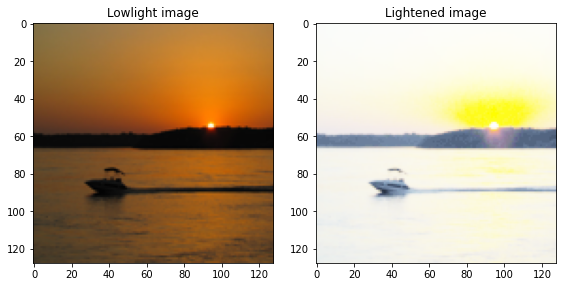

epoch: 34 	step: 20 / 87 	train loss: 1.0465 	time: 2.7070 s
epoch: 34 	step: 40 / 87 	train loss: 1.0304 	time: 2.7077 s
epoch: 34 	step: 60 / 87 	train loss: 1.0496 	time: 2.7053 s
epoch: 34 	step: 80 / 87 	train loss: 0.9271 	time: 2.7046 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 34 / 40 	train loss: 1.0751 	valid loss: 1.1062
Model saved to: model.pth


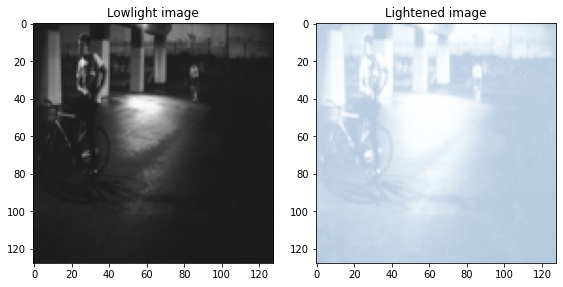

epoch: 35 	step: 20 / 87 	train loss: 1.0694 	time: 2.7045 s
epoch: 35 	step: 40 / 87 	train loss: 0.9874 	time: 2.7104 s
epoch: 35 	step: 60 / 87 	train loss: 1.0480 	time: 2.7074 s
epoch: 35 	step: 80 / 87 	train loss: 1.2342 	time: 2.7089 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 35 / 40 	train loss: 1.0710 	valid loss: 1.0999
Model saved to: model.pth


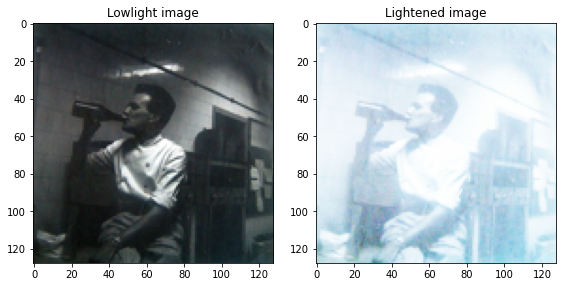

epoch: 36 	step: 20 / 87 	train loss: 1.1824 	time: 2.7037 s
epoch: 36 	step: 40 / 87 	train loss: 1.0527 	time: 2.7047 s
epoch: 36 	step: 60 / 87 	train loss: 1.0679 	time: 2.7095 s
epoch: 36 	step: 80 / 87 	train loss: 1.0745 	time: 2.7058 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 36 / 40 	train loss: 1.0710 	valid loss: 1.0968
Model saved to: model.pth


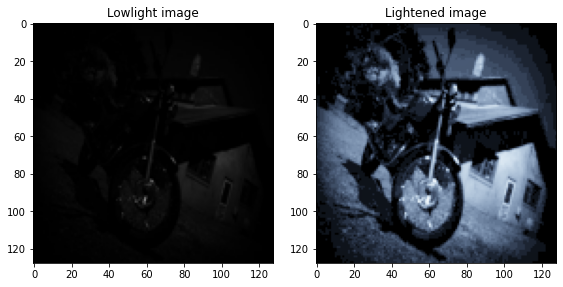

epoch: 37 	step: 20 / 87 	train loss: 1.0970 	time: 2.7023 s
epoch: 37 	step: 40 / 87 	train loss: 1.1478 	time: 2.7057 s
epoch: 37 	step: 60 / 87 	train loss: 1.0904 	time: 2.7036 s
epoch: 37 	step: 80 / 87 	train loss: 1.1509 	time: 2.7075 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 37 / 40 	train loss: 1.0668 	valid loss: 1.0933
Model saved to: model.pth


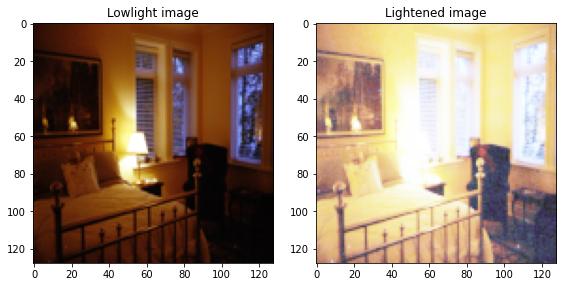

epoch: 38 	step: 20 / 87 	train loss: 1.1101 	time: 2.7092 s
epoch: 38 	step: 40 / 87 	train loss: 1.1059 	time: 2.7064 s
epoch: 38 	step: 60 / 87 	train loss: 1.1208 	time: 2.7092 s
epoch: 38 	step: 80 / 87 	train loss: 0.9723 	time: 2.7074 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 38 / 40 	train loss: 1.0670 	valid loss: 1.0982
INFO: Early stopping counter 1 of 3


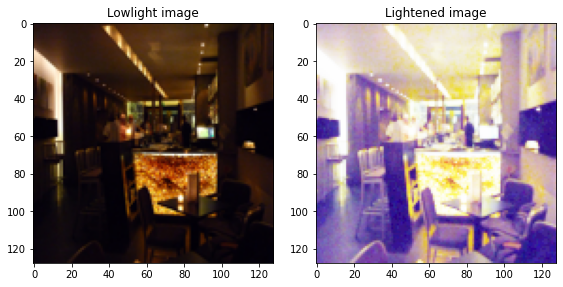

epoch: 39 	step: 20 / 87 	train loss: 1.0730 	time: 2.7046 s
epoch: 39 	step: 40 / 87 	train loss: 1.1490 	time: 2.7087 s
epoch: 39 	step: 60 / 87 	train loss: 1.0806 	time: 2.7039 s
epoch: 39 	step: 80 / 87 	train loss: 1.1090 	time: 2.7073 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 39 / 40 	train loss: 1.0659 	valid loss: 1.0923
Model saved to: model.pth


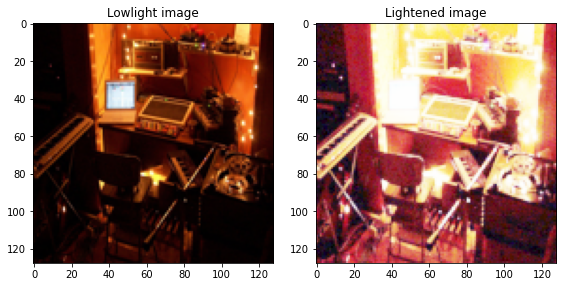

epoch: 40 	step: 20 / 87 	train loss: 1.0730 	time: 2.7085 s
epoch: 40 	step: 40 / 87 	train loss: 0.9455 	time: 2.7062 s
epoch: 40 	step: 60 / 87 	train loss: 1.0026 	time: 2.7081 s
epoch: 40 	step: 80 / 87 	train loss: 1.0592 	time: 2.7105 s


  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 40 / 40 	train loss: 1.0625 	valid loss: 1.0889
Model saved to: model.pth


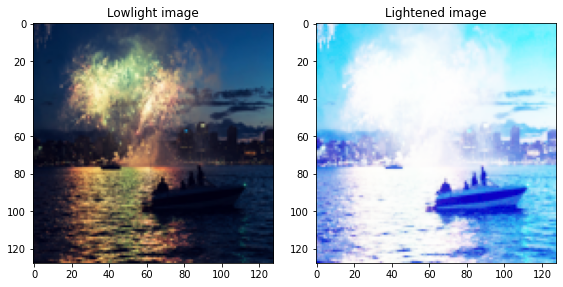

In [11]:
import time

EPOCHS = 40
print_freq = 20

for epoch in range(1, EPOCHS+1):

    train_loss = []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss = []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        
    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss))
         )
    
    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))
    
    test_plot(model)